In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import cv2 as cv
import os

from sklearn.utils import shuffle

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
!unzip -q /content/drive/MyDrive/VAE/sign_language.zip

In [4]:
# Define image size
SIZE=100

In [5]:
# load data
def load_subdata(data,SIZE):
    X1 = []
    y1 = []
    size = SIZE
    lbl = 0
    dic = {}
    for folder_name in os.listdir(data):
        
        Label = lbl
        dic[folder_name] = Label  
        count_img = 0;

        for filename in os.listdir(data + '/' + folder_name):
            image = tf.keras.preprocessing.image.load_img(data +'/'+ folder_name + '/' + filename,color_mode='rgb', target_size=(size,size))
            arr = keras.preprocessing.image.img_to_array(image)
            X1.append(np.array([arr]))
            y1.append(Label) 
        lbl +=1   
         
    X1 = np.asarray(X1).reshape(len(X1),SIZE,SIZE,3).astype(np.int16)
    X1 = X1.astype('float')/255.
    y1 = np.asarray(y1).astype(np.uint8)
    return X1,y1, dic

images, y, label_dic = load_subdata(r'Sign Language Dataset', SIZE)

In [6]:
# Shuffle data for training neural network
images, y = shuffle(images, y, random_state=25)

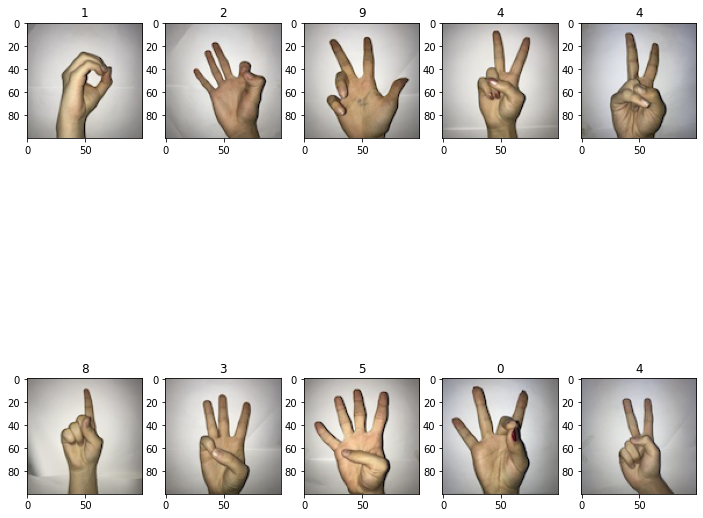

In [7]:
# Plot some example images with their labels
plt.figure(figsize = (12,12))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(y[i])
plt.show()

In [8]:
# Define class for sampling layer to VAE model
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
# ENCODER

LATENT_DIM = 2

encoder_inputs = keras.Input(shape=(SIZE, SIZE, 3))
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 25, 25, 256)  295168      ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 160000)       0           ['conv2d_1[0][0]']         

In [10]:
# DECODER
latent_inputs = keras.Input(shape=(LATENT_DIM,))
x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(25 * 25 * 256, activation="relu")(x)
x = layers.Reshape((25, 25, 256))(x)
x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 16)                48        
                                                                 
 dense_6 (Dense)             (None, 32)                544       
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dense_10 (Dense)            (None, 160000)            4112

In [11]:
# Define VAE Model

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [12]:
# Compile model
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [13]:
# Train model
history = vae.fit(images, epochs=500, batch_size=64)

Epoch 1/500
33/33 [==============================] - 23s 236ms/step - loss: 6590.9201 - reconstruction_loss: 6438.3179 - kl_loss: 7.4889
Epoch 2/500
33/33 [==============================] - 7s 221ms/step - loss: 6319.7400 - reconstruction_loss: 6303.9092 - kl_loss: 7.0550
Epoch 3/500
33/33 [==============================] - 7s 222ms/step - loss: 6291.5469 - reconstruction_loss: 6291.1646 - kl_loss: 5.7185
Epoch 4/500
33/33 [==============================] - 7s 223ms/step - loss: 6293.1365 - reconstruction_loss: 6282.3184 - kl_loss: 4.9141
Epoch 5/500
33/33 [==============================] - 8s 231ms/step - loss: 6275.6218 - reconstruction_loss: 6282.7983 - kl_loss: 4.0563
Epoch 6/500
33/33 [==============================] - 7s 225ms/step - loss: 6291.8597 - reconstruction_loss: 6274.3511 - kl_loss: 4.2745
Epoch 7/500
33/33 [==============================] - 7s 227ms/step - loss: 6273.8975 - reconstruction_loss: 6263.3232 - kl_loss: 4.7539
Epoch 8/500
33/33 [============================

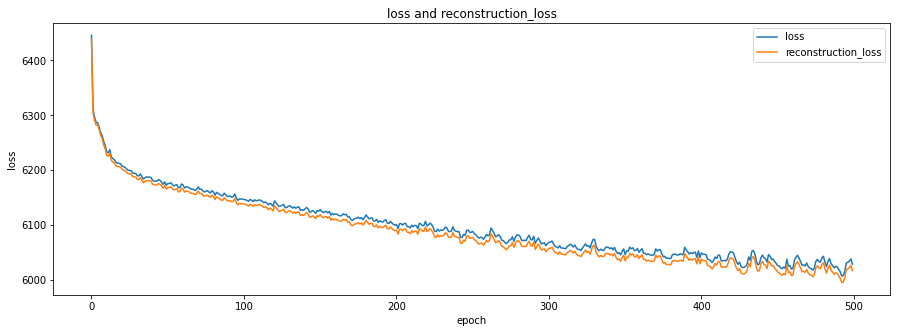

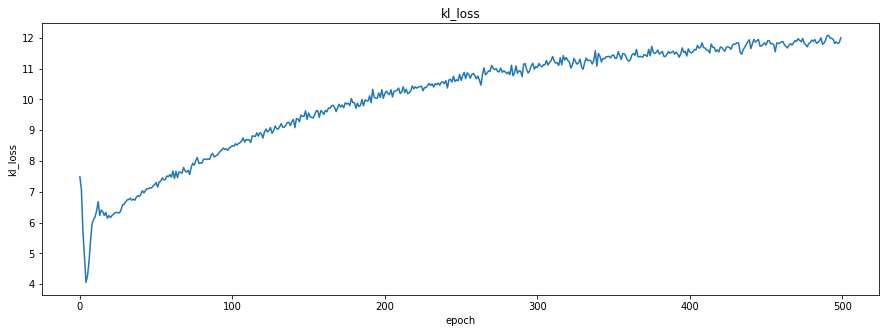

In [14]:
# Plot training process
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['reconstruction_loss'], label="reconstruction_loss")
plt.title('loss and reconstruction_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'reconstruction_loss'], loc='upper right')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(history.history['kl_loss'], label="kl_loss")
plt.title('kl_loss')
plt.ylabel('kl_loss')
plt.xlabel('epoch')
plt.show()

65/65 [==============================] - 1s 6ms/step


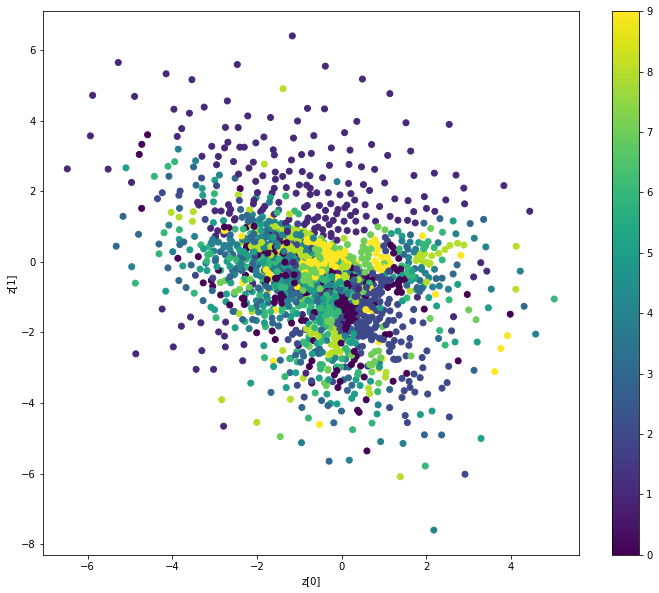

In [15]:
# plot labels in the latent space
def plot_label_clusters(vae, data, labels):
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(vae, images, y)

In [16]:
encoded, _, _  = vae.encoder.predict(images)
encoded = pd.DataFrame({
    'z0':encoded[:, 0],
    'z1':encoded[:, 1],
    'label':y
})
encoded

65/65 [==============================] - 0s 6ms/step


,z0,z1,label
0,-2.689070,3.392746,1
1,1.499154,-4.355105,2
2,-0.091230,0.171512,9
3,-2.015524,-1.103701,4
4,-0.154549,-0.371122,4
...,...,...,...
2057,-0.151634,-0.137394,9
2058,0.834869,-4.310733,5
2059,-0.406087,4.337418,1
2060,2.539202,3.898727,1


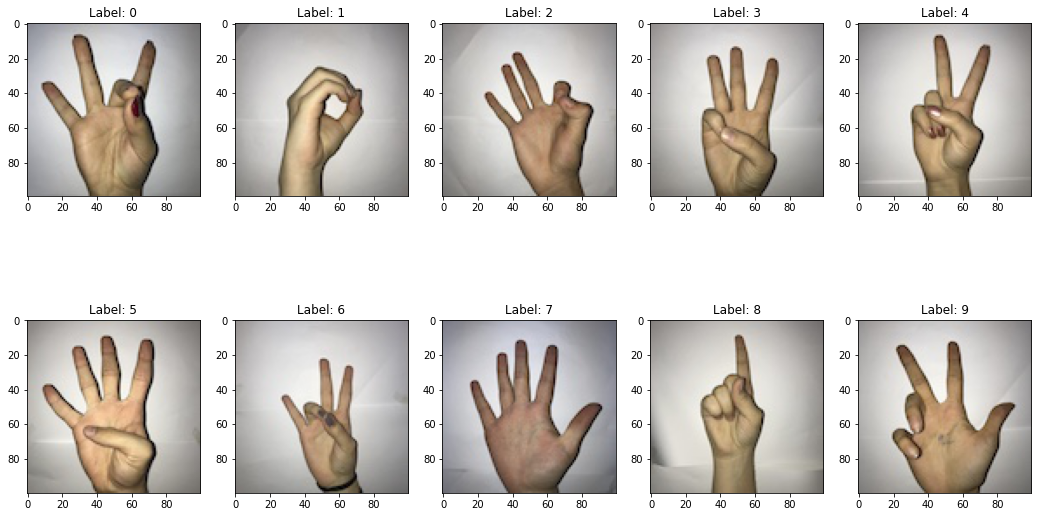

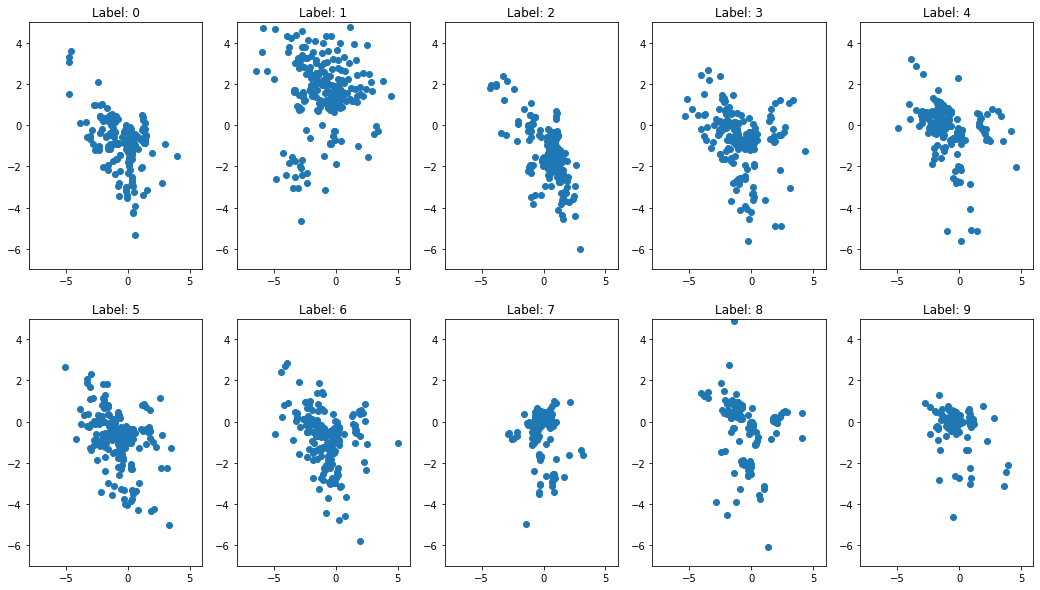

In [17]:
# plot images from each label in latent space in separate plots
images_with_labels = (images, y)

plt.figure(figsize = (18,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images_with_labels[0][images_with_labels[1] == i][0], cmap='gray')
    plt.title(f'Label: {images_with_labels[1][images_with_labels[1] == i][0]}')
plt.show()
del images_with_labels

fig, ax = plt.subplots(nrows=2, ncols=5, figsize = (18,10))
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].scatter(encoded[encoded.label == k]['z0'], encoded[encoded.label == k]['z1'])
        ax[i,j].set_title(5)
        ax[i,j].set_ylim(-7, 5)
        ax[i,j].set_xlim(-8, 6)
        ax[i,j].set_title(f'Label: {k}')
        k=k+1
plt.show()
del k

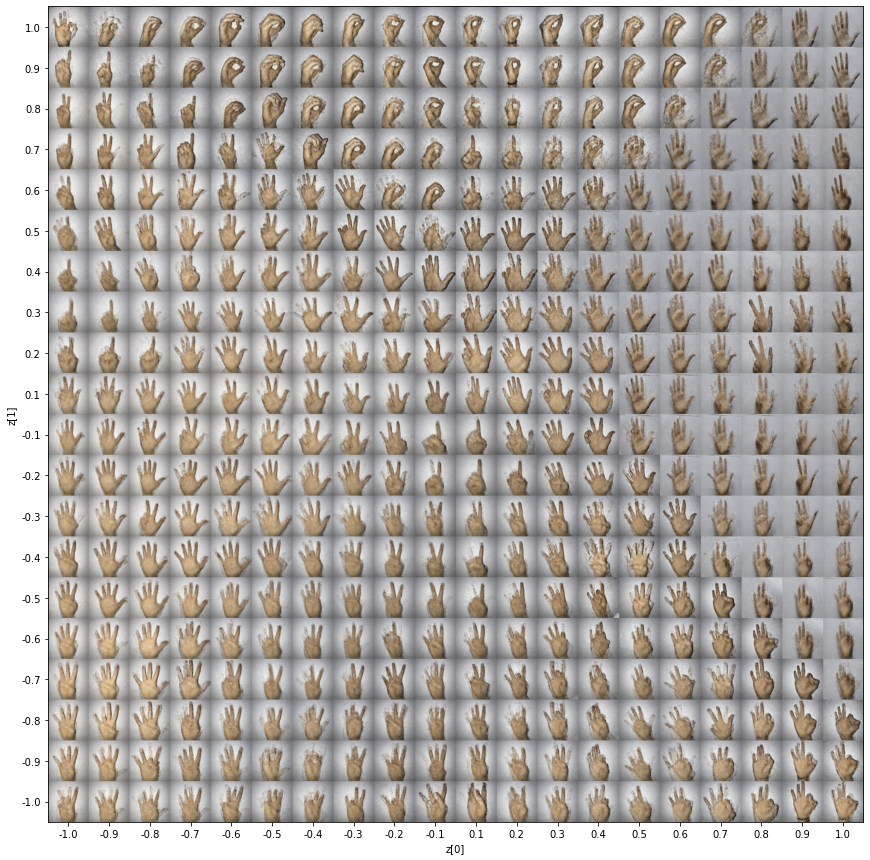

In [18]:
# plot latent space
def plot_latent_space(vae, n=20, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 100
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n, 3))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose = 0)
            digit = x_decoded[0].reshape(digit_size, digit_size, 3)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)